In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
# from dance_evaluation import *
import matplotlib.pyplot as plt
# from calculate_score import *
from collections import defaultdict

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

def save_to_pickle(filepath, data):
    # filepath = os.path.join(savepath, filename)
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

#### New Update March 12

In [2]:

def compute_dts(
    ref_bpm,
    estimated_bpm,
    tau=0.06,
    mode="one"
):
    """
    Continuous Dance-Tempo Score (DTS), with support for
    either single estimates (mode="one") or multiple
    candidates per frame (mode="many").

    Parameters
    ----------
    ref_bpm : array-like, shape (n,)
        Ground-truth musical tempo in BPM.
    estimated_bpm : 
        If mode="one": array-like, shape (n,)
        If mode="many": iterable of length-n, each element
                        is an iterable of candidate BPMs.
    tau : float, optional
        Tolerance in octaves (0.06 ≈ 4 %).
    mode : {"one", "many"}
        “one”: treat `estimated_bpm` as a flat sequence.
        “many”: pick, for each i, the candidate closest to ref_bpm[i].

    Returns
    -------
    dts : ndarray, shape (n,)
        Scores in [0, 1] (1 = perfect, 0 = miss ≥ τ octaves away).
    e : ndarray, shape (n,)
        Raw octave errors log₂(estimate/ref).
    d : ndarray, shape (n,)
        Wrapped distance to {-1, 0, +1} before clipping.
    """
    ref_bpm = np.asarray(ref_bpm, dtype=float)

    # select a single estimate per index if needed
    if mode == "many":
        # estimated_bpm is e.g. [(b1, b2,...), (c1, c2,...), ...]
        chosen = np.array([
            min(cands, key=lambda b: abs(b - ref_bpm[i]))
            for i, cands in enumerate(estimated_bpm)
        ], dtype=float)
    elif mode == "one":
        chosen = np.asarray(estimated_bpm, dtype=float)
    else:
        raise ValueError(f"Unknown mode: {mode!r}. Use 'one' or 'many'.")

    # now compute the DTS exactly as before
    e = np.log2(chosen / ref_bpm)
    # distance from nearest of -1, 0, +1
    d = np.abs(e[:, None] - np.array([-1.0, 0.0, 1.0])).min(axis=1)
    # clip by tolerance and convert to score
    d_clip = np.minimum(d, tau)
    dts    = 1.0 - d_clip / tau

    accuracy = (dts > 0.0).mean() * 100
    
    # hits ----------------------------------------------------------
    hit_mask = dts > 0.0          # inside ±tau band
    hit_idx = np.nonzero(hit_mask)[0]
    ref_hit_bpm = ref_bpm[hit_idx]
    
    return dts, e, d, accuracy


### For adaptive weighting

In [3]:
from collections import defaultdict

# path setup
a, b = 25, 140
root = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result"
pth_pos = f"{root}/tttempo_{a}_{b}/pos"
pth_vel = f"{root}/tttempo_{a}_{b}/vel"

# descriptive labels for plot axis
friendly = {
    "adaptv_Bhandfoot_y":  "Both-Hand + Foot (Y)",
    "adaptv_LRfoot_xy":    "L-/R-Foot (XY)",
    "adaptv_LRfoot_res":   "L-/R-Foot (Resultant)",
    "adaptv_LRhand_xy":    "L-/R-Hand (XY)",
    "adaptv_LRhand_res":   "L-/R-Hand (Resultant)",
    "adaptv_Bfoot_x_y":    "Both-Foot (X & Y)",
    "adaptv_Bhandfoot_x":  "Both-Hand & Both-Foot (X)",
    "adaptv_Bhand_x_y":    "Both-Hand (X & Y)",
    "adaptv_Bhandfoot_res":"Both-Hand & Both-Foot (Resultant)",
}

# helper to compute accuracy and fill a dictionary
def collect_accuracies(folder, metric_tag):
    acc = {}
    for fname in os.listdir(folder):
        tag = fname.split("_zero_uni")[0]
        data = load_pickle(f"{folder}/{fname}")
        ref  = data["music_tempo"].to_numpy()
        _, _, _, accuracy = compute_dts(ref, data["bpm_median"].to_numpy(),
                                        tau=0.10, mode="one")
        acc[friendly[tag] ] = round(accuracy, 2)
    return acc

# build two dicts, one for pos and one for vel, ready for bar plotting
accuracy_dict_pos = collect_accuracies(pth_pos, "pos")
accuracy_dict_vel = collect_accuracies(pth_vel, "vel")

# optional: merge if you prefer a single dictionary
accuracy_dict = {**accuracy_dict_pos, **accuracy_dict_vel}


In [4]:
accuracy_dict

{'Both-Hand + Foot (Y)': 58.02,
 'L-/R-Foot (XY)': 35.5,
 'L-/R-Foot (Resultant)': 0.0,
 'L-/R-Hand (XY)': 45.19,
 'L-/R-Hand (Resultant)': 0.0,
 'Both-Foot (X & Y)': 43.33,
 'Both-Hand & Both-Foot (X)': 26.25,
 'Both-Hand (X & Y)': 48.77,
 'Both-Hand & Both-Foot (Resultant)': 0.0}

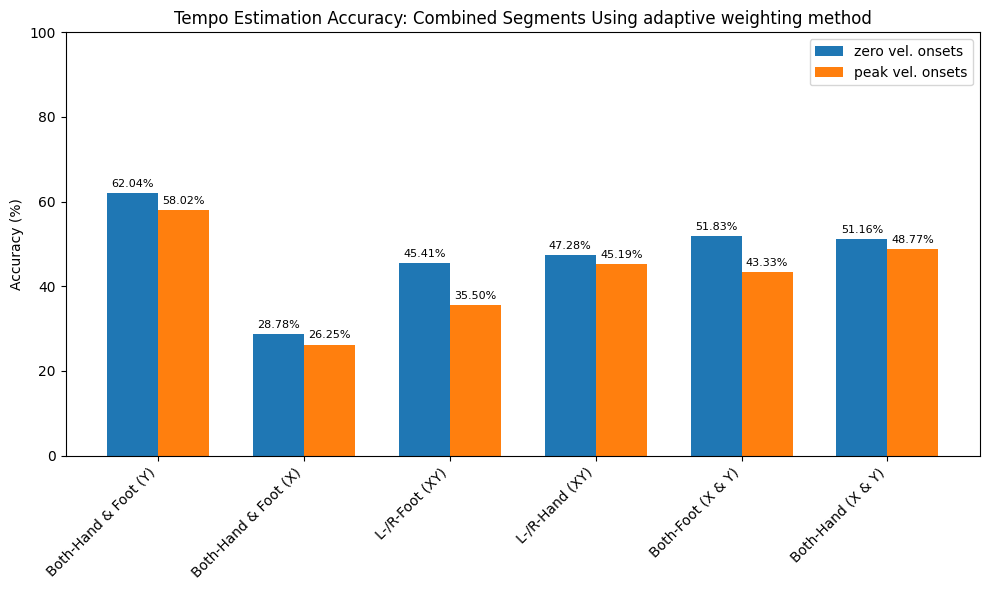

In [ ]:

# Given accuracy dictionaries
accuracy_pos = {
    'Both-Hand & Foot (Y)': 62.04,
    'Both-Hand & Foot (X)': 28.78,
    'L-/R-Foot (XY)': 45.41,
    'L-/R-Hand (XY)': 47.28,
    'Both-Foot (X & Y)': 51.83,
    'Both-Hand (X & Y)': 51.16,
}

accuracy_vel = {
    'Both-Hand & Foot (Y)': 58.02,
    'Both-Hand & Foot (X)': 26.25,
    'L-/R-Foot (XY)': 35.5,
    'L-/R-Hand (XY)': 45.19,
    'Both-Foot (X & Y)': 43.33,
    'Both-Hand (X & Y)': 48.77,
}

# Labels and values
labels = list(accuracy_pos.keys())
pos_vals = [accuracy_pos[k] for k in labels]
vel_vals = [accuracy_vel[k] for k in labels]

# Plot settings
x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars_pos = plt.bar(x - bar_width/2, pos_vals, bar_width, label='zero vel. onsets', color='tab:blue')
bars_vel = plt.bar(x + bar_width/2, vel_vals, bar_width, label='peak vel. onsets', color='tab:orange')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Tempo Estimation Accuracy: Combined Segments Using adaptive weighting method')
plt.ylim(0, 100)

# Annotate percentages on top of bars
for bar in bars_pos:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

for bar in bars_vel:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()


### Functions

In [18]:
def estimate_tempo_posvel(a, b, mode, w_sec, h_sec):
    # Using both zero velocity and peak velocity
    segment_pairs = [
        ("both_hand_x", "both_foot_x"),                     # Example: bpm_pos ~35%, bpm_posvel ~55%
        ("both_hand_y", "both_foot_y"),                     # Example: bpm_pos ~70%, bpm_posvel ~81%
        ("both_hand_resultant", "both_foot_resultant"),     # Example: bpm_pos ~49%, bpm_posvel ~66%

    ]
    
    score_data = {}
    json_data = {}
    oPath = f"./saved_result/tempo_{a}_{b}/"
    # win_path = "./saved_result/window_cases/pos"
    # tem_path = f"./saved_result/tempo_cases/tempo_{a}_{b}/pos"
    bpm_dict = ["bpm_avg",  "bpm_mode", "bpm_median"]
    for bpm_mode in bpm_dict:
        score_data[bpm_mode] = {}
        json_data[bpm_mode] = {}
        for hnd, ft in segment_pairs:
            # Build file paths for position and velocity data
            read_file1 = oPath + f"pos/{hnd}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            read_file2 = oPath + f"pos/{ft}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            read_file3 = oPath + f"vel/{hnd}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            read_file4 = oPath + f"vel/{ft}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            
            # Load the dataframes
            df1 = pd.read_pickle(read_file1)
            df2 = pd.read_pickle(read_file2)
            df3 = pd.read_pickle(read_file3)
            df4 = pd.read_pickle(read_file4)
            
            # Build candidate BPM pairs (for positions) and quads (for positions and velocities)
            bpm_pos = []
            bpm_vel = []
            bpm_posvel = []
            for n in range(df1.shape[0]):
                bpm1 = df1.iloc[n][bpm_mode]   # hand (position)
                bpm2 = df2.iloc[n][bpm_mode]   # foot (position)
                bpm3 = df3.iloc[n][bpm_mode]   # hand (velocity)
                bpm4 = df4.iloc[n][bpm_mode]   # foot (velocity)
                
                bpm_pos.append((bpm1, bpm2))
                bpm_vel.append((bpm3, bpm4))
                bpm_posvel.append((bpm1, bpm2, bpm3, bpm4))
            
            # music_tempo from df1 
            ref = df1["music_tempo"].to_numpy()
            
            # Calculate metrics for the candidate
            _, _, _, dts_acc1 = compute_dts(ref, bpm_pos, tau=0.10, mode = "many")
            _, _, _, dts_acc2 = compute_dts(ref, bpm_vel, tau=0.10, mode = "many")
            _, _, _, dts_acc3 = compute_dts(ref, bpm_posvel, tau=0.10, mode = "many")

            pair_key = f"{hnd}_{ft}"
            
            # score_data[bpm_mode][pair_key] = {"metrics_pos": dts_acc1, "metrics_vel": dts_acc2, "metrics_posvel": dts_acc3}
                
            
            json_data[bpm_mode][pair_key] = {"bpm_pos": bpm_pos,
                                             "bpm_vel": bpm_vel,
                                            "bpm_posvel": bpm_posvel,
                                            "Acc1_bpm_pos": dts_acc1,
                                            "Acc1_bpm_vel": dts_acc2,
                                            "Acc1_bpm_posvel": dts_acc3,}
            
    
    #### Sace the score data to a pickle file
    # save_dir = f"./saved_result/tempo_{a}_{b}/score"
    # fname1 = f"score_multi_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
    # fpath1 = os.path.join(save_dir, fname1)
    # save_to_pickle(fpath1, score_data)
        
    return json_data

def estimate_tempo_one(a, b, mode, metric, w_sec, h_sec):

    segment_keys = [
                    "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
                    "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                    
                    "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
                    "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                    
                    "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
                     "both_hand_resultant", "both_foot_resultant", # resultant of x and y onsets
                    ] # "bothhand_xy", "bothfoot_xy",
    score_data = {}
    json_data = {}
    bpm_dict = ["bpm_avg",  "bpm_mode", "bpm_median"]
    oPath = f"./saved_result/tempo_{a}_{b}/"
    for bpm_mode in bpm_dict:
        score_data[bpm_mode] = {}
        json_data[bpm_mode] = {}
        for idx, f_name in enumerate(segment_keys):
            f_path = oPath + f"{metric}/{f_name}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            df_ax = pd.read_pickle(f_path)
            
            ref = df_ax["music_tempo"].to_numpy()
            _, _, _, dts_acc = compute_dts(ref, np.asarray(df_ax[bpm_mode]), tau=0.10, mode = "one")
            
            # score_data[bpm_mode][f_name] = {f"metrics_{metric}": metrics}
                                    
            json_data[bpm_mode][f_name] = {"Acc1_bpm_one": dts_acc}
            # json_data[bpm_mode][f_name] = metrics     # new
            
    
    #### Save the score data to a pickle file
    # save_dir = f"./saved_result/tempo_{a}_{b}/score"
    # fname1 = f"score_one_{metric}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
    # fpath1 = os.path.join(save_dir, fname1)
    # save_to_pickle(fpath1, score_data)
    
    return json_data

# a = 25; b= 60
# mode = "zero_uni"
# w_sec = 5; h_sec = w_sec/2

# jdata1 = estimate_tempo_posvel(a, b, mode, w_sec, h_sec)      # overall acc1 per body segment
# jdata2 = estimate_tempo_one(a, b, mode, "pos", w_sec, h_sec)    # overall acc1 per body segment

# Plot Section

### V1: Grouped Bar Plot: Tempo of independant body segment

In [ ]:
# segment = [
#                 "left_hand_x", "left_hand_y", "right_hand_x", "right_hand_y",   # singular
#                 "left_foot_x", "left_foot_y", "right_foot_x", "right_foot_y",   # singular
                
#                 "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
#                 "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                
#                 "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
#                 "bothhand_xy", "bothfoot_xy",
#                 "both_hand_resultant", "both_foot_resultant", 
#                 ] 

segments_1 = [
        "left_hand_x", "left_hand_y", "right_hand_x", "right_hand_y",   # singular
        "left_foot_x", "left_foot_y", "right_foot_x", "right_foot_y",   # singular
        ]


a = 25; b= 140
metric = "pos"
mode = "zero_bi"
w_sec = 5; h_sec = w_sec/2

t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)

accuracies1 = [round(t_data["bpm_median"][seg]['Acc1_bpm_one']) for seg in segments_1]

# Define labels
labels = [
    'L-Hand-X', 'L-Hand-Y', 'R-Hand-X', 'R-Hand-Y',
    'L-Foot-X', 'L-Foot-Y', 'R-Foot-X', 'R-Foot-Y',
]

bar_colors = [
    '#AEC6CF', '#8FB1C2',  # Left Hand (light & darker pastel blue)
    '#C3B1E1', '#A28DC8',  # Right Hand (light & darker pastel lavender)
    '#B0DAB9', '#92C9A0',  # Left Foot (light & darker pastel green)
    '#FFDAC1', '#E8BEA3',  # Right Foot (light & darker pastel peach)
    '#FFB7B2', '#E59893',  # Both Hands (light & darker pastel pink)
    '#FDFD96', '#E7E27D'   # Both Feet (light & darker pastel yellow)
]

# Parameter to control bar width
bar_width = 0.15

# Number of pairs
n_pairs = len(labels) // 2

# Positioning pairs
pair_spacing = 0.15  # space between pairs
inner_spacing = 0.05  # gap between bars within a pair

# Calculate positions for bars to group them in pairs
positions = []
for i in range(n_pairs):
    start_pos = i * (2 * bar_width + pair_spacing)
    positions.extend([start_pos, start_pos + bar_width + inner_spacing])

x = np.array(positions)

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(x, accuracies1, color=bar_colors, edgecolor='gray', width=bar_width)

# Customize plot
plt.xticks(x, labels, rotation=60)
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Tempo Estimation Accuracy across Single Body Segment (Single Axis)')
plt.ylim(0, 100)

# Annotate bar heights
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{bar.get_height()}%', ha='center', fontsize=9)

plt.tight_layout()
# plt.savefig("plots/plot_1a.eps")
plt.show()

### V2: Grouped Bar Plot: Tempo of independant body segment

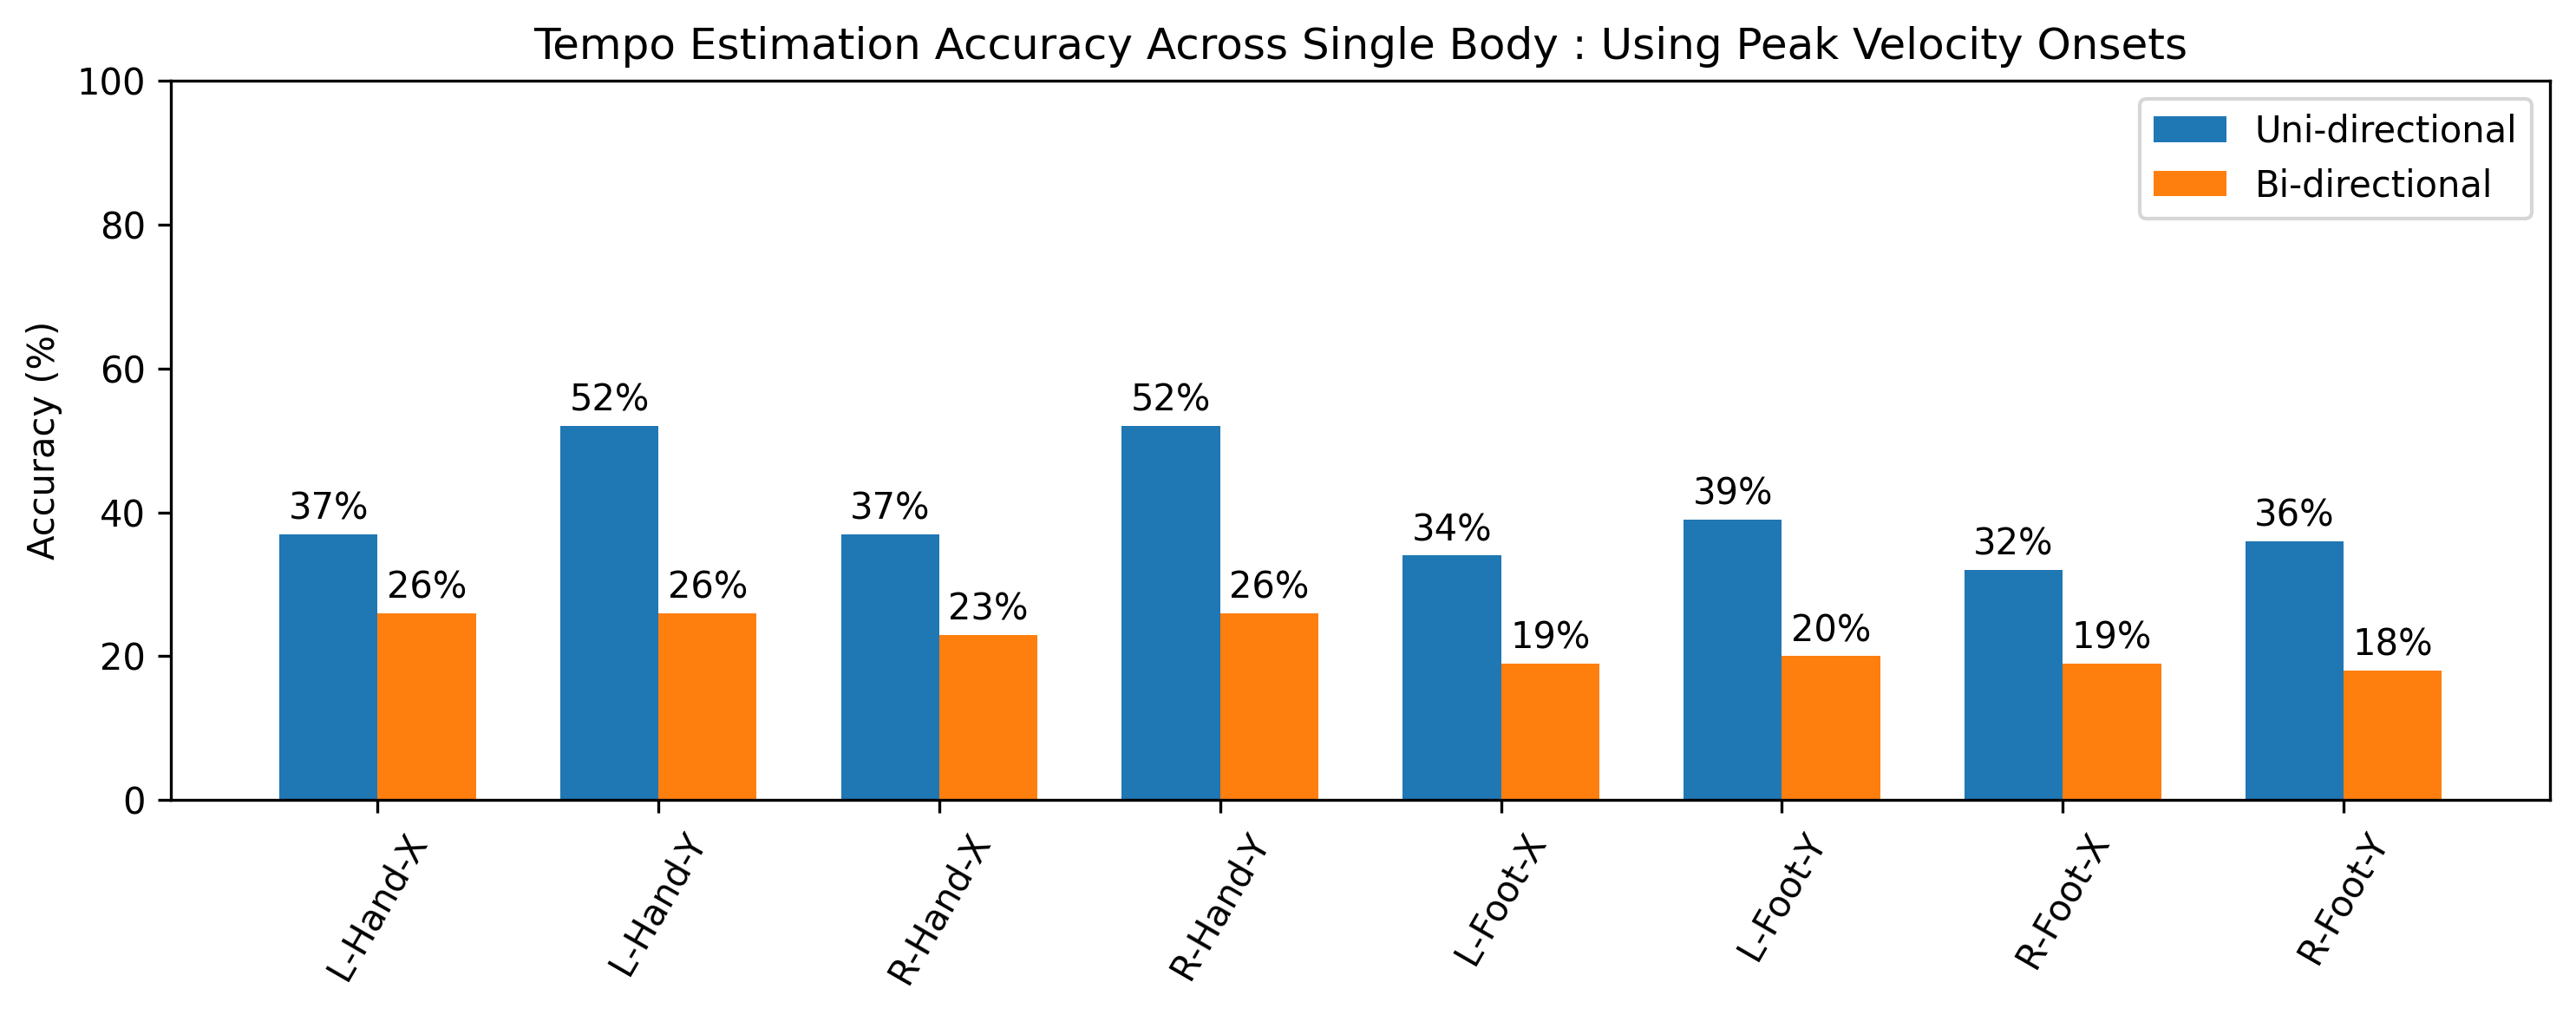

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Your parameters
a, b = 25, 140
metric = "vel"
w_sec, h_sec = 5, 5/2

segments = [
    "left_hand_x", "left_hand_y", "right_hand_x", "right_hand_y",
    "left_foot_x", "left_foot_y", "right_foot_x", "right_foot_y",
]

labels = [
    'L-Hand-X', 'L-Hand-Y', 'R-Hand-X', 'R-Hand-Y',
    'L-Foot-X', 'L-Foot-Y', 'R-Foot-X', 'R-Foot-Y',
]

# Compute accuracies for each mode
modes = ["zero_uni", "zero_bi"]
acc = {}
for mode in modes:
    t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)
    acc[mode] = np.array([
        round(t_data["bpm_median"][seg]['Acc1_bpm_one'])
        for seg in segments
    ])

# Plotting
bar_width = 0.35
x = np.arange(len(labels))

plt.figure(figsize=(10, 4), dpi=300)
plt.bar(x - bar_width/2, acc["zero_uni"],  bar_width, label="Uni-directional", color = "tab:blue")
plt.bar(x + bar_width/2, acc["zero_bi"],  bar_width, label="Bi-directional", color = "tab:orange")

plt.xticks(x, labels, rotation=60)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.title("Tempo Estimation Accuracy Across Single Body : Using Peak Velocity Onsets")
plt.legend()

# annotate
for i in range(len(x)):
    plt.text(x[i] - bar_width/2, acc["zero_uni"][i] + 1,
             f"{acc['zero_uni'][i]}%", ha="center", va="bottom")
    plt.text(x[i] + bar_width/2, acc["zero_bi"][i] + 1,
             f"{acc['zero_bi'][i]}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("plots/plot_1a_peak_vel.png")
plt.show()


### V1 Bar plot: XY and resultant

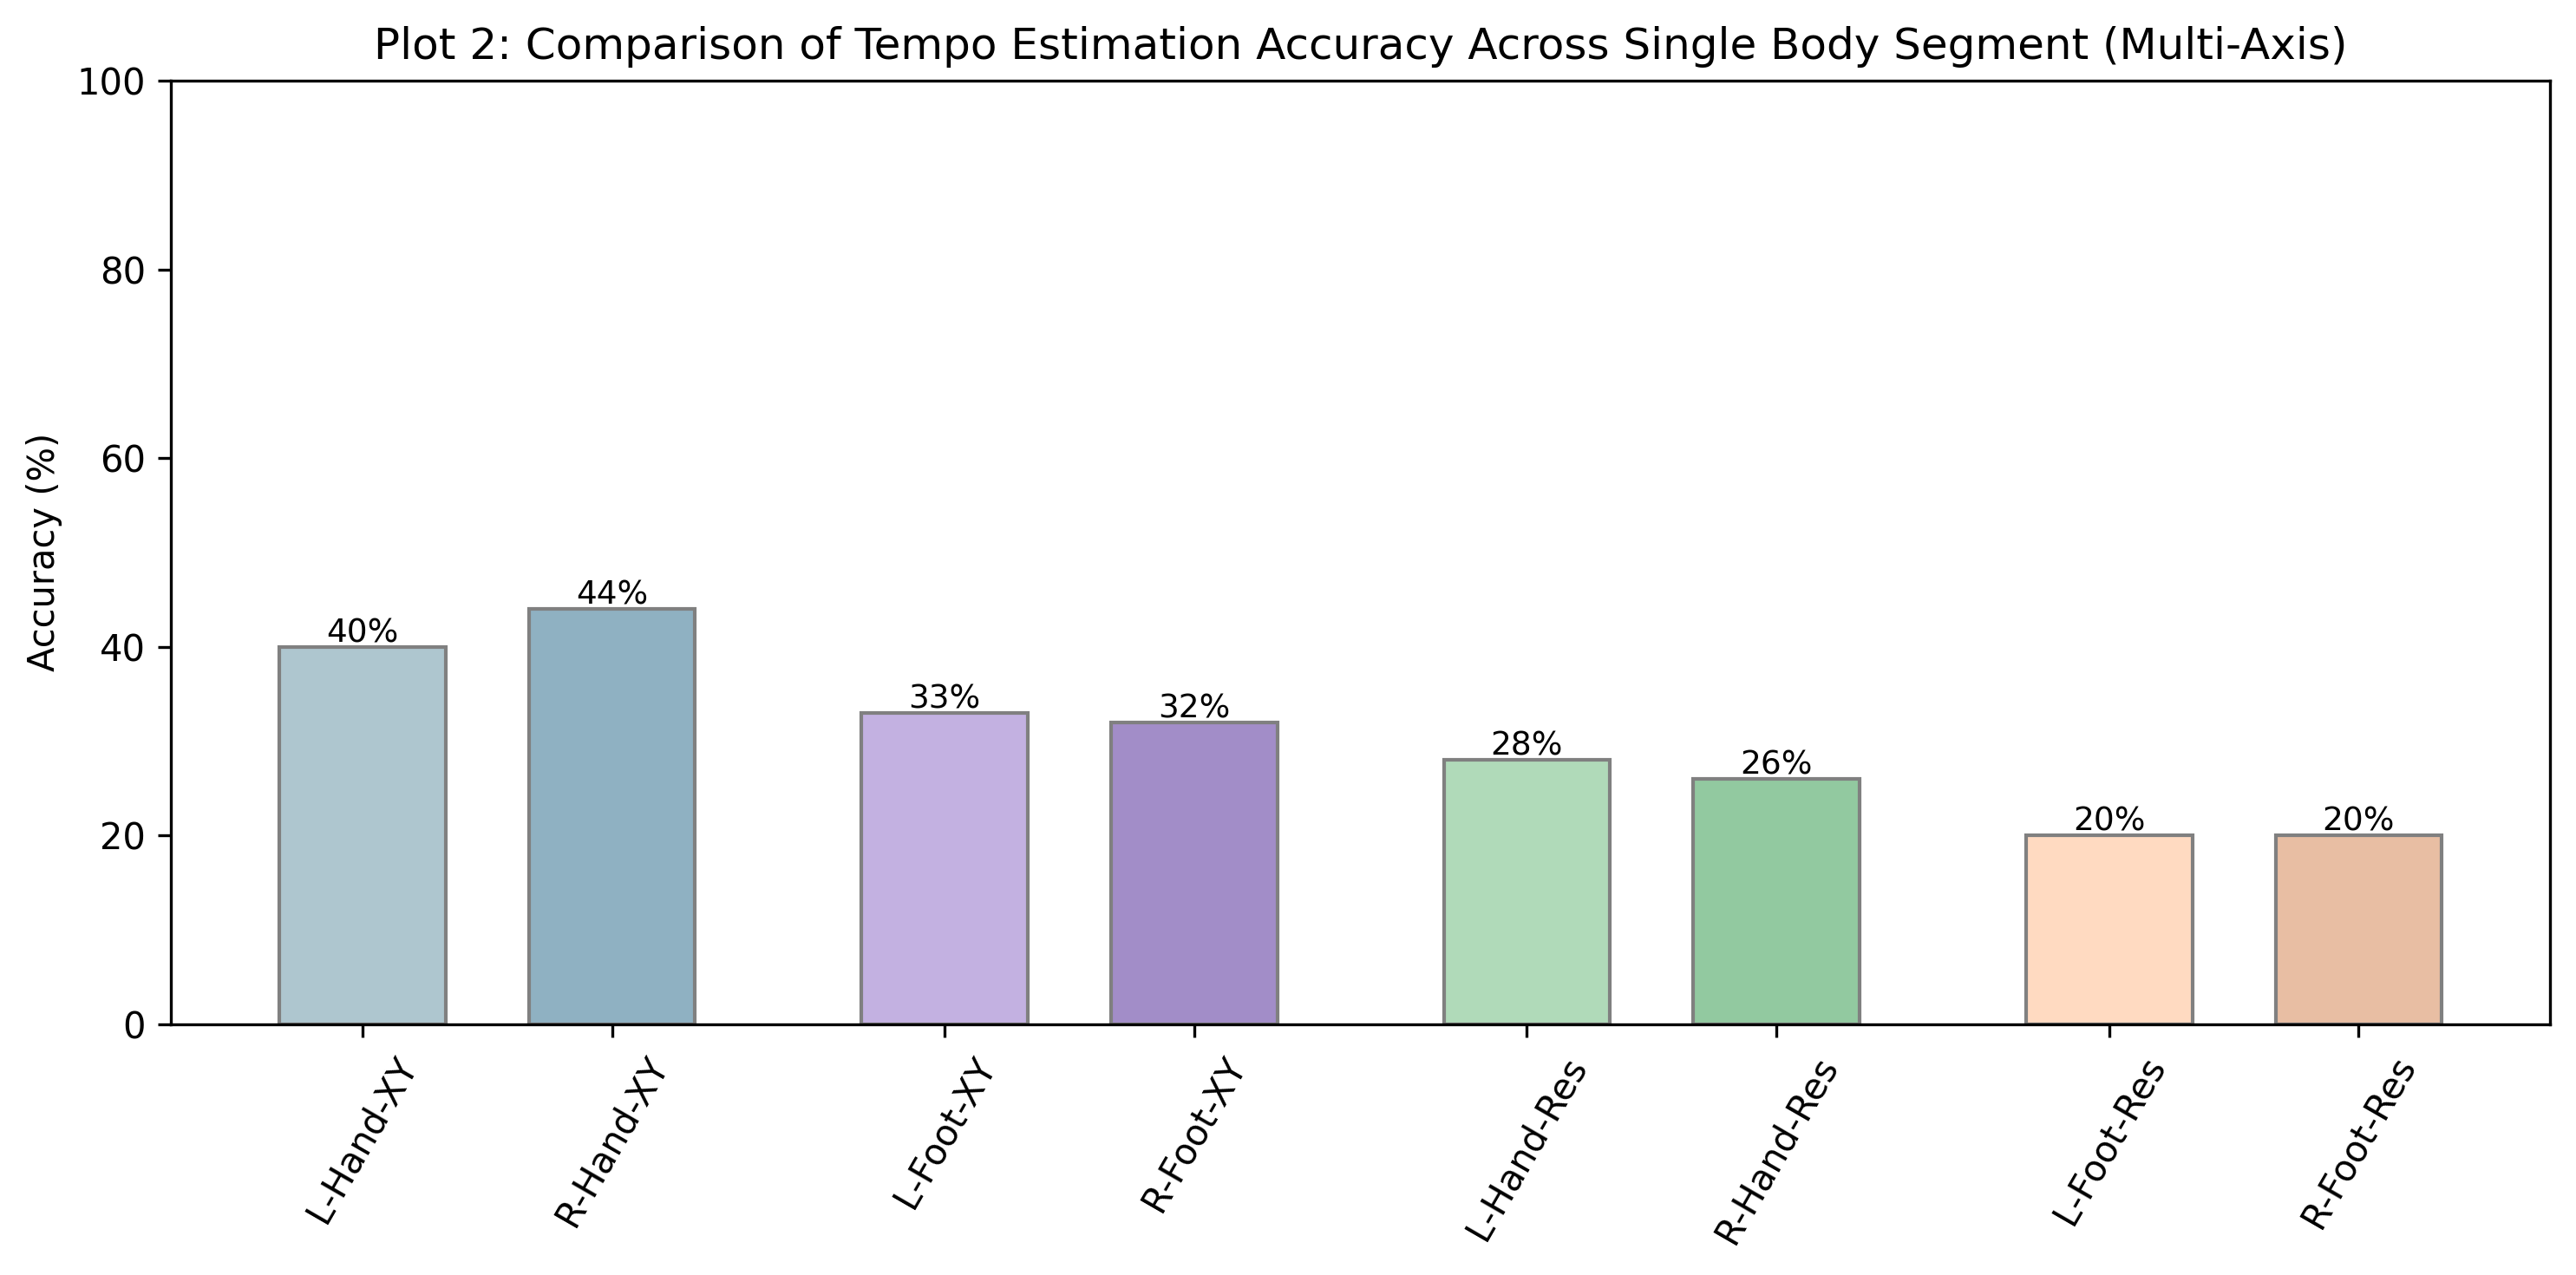

In [31]:
segments_2 = [
        "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
        "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",
        ]

# a = 60; b= 140
metric = "vel"
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)

accuracies = [round(t_data['bpm_median'][seg]['Acc1_bpm_one']) for seg in segments_2]

# Define labels
labels = [
    'L-Hand-XY', 'R-Hand-XY', 'L-Foot-XY', 'R-Foot-XY',
    'L-Hand-Res', 'R-Hand-Res', 'L-Foot-Res', 'R-Foot-Res',
]

bar_colors = [
    '#AEC6CF', '#8FB1C2',  # Left Hand (light & darker pastel blue)
    '#C3B1E1', '#A28DC8',  # Right Hand (light & darker pastel lavender)
    '#B0DAB9', '#92C9A0',  # Left Foot (light & darker pastel green)
    '#FFDAC1', '#E8BEA3',  # Right Foot (light & darker pastel peach)
    # '#FFB7B2', '#E59893',  # Both Hands (light & darker pastel pink)
    # '#FDFD96', '#E7E27D'   # Both Feet (light & darker pastel yellow)
]

# Parameter to control bar width
bar_width = 0.10

# Number of pairs
n_pairs = len(labels) // 2

# Positioning pairs
pair_spacing = 0.15  # space between pairs
inner_spacing = 0.05  # gap between bars within a pair

# Calculate positions for bars to group them in pairs
positions = []
for i in range(n_pairs):
    start_pos = i * (2 * bar_width + pair_spacing)
    positions.extend([start_pos, start_pos + bar_width + inner_spacing])

x = np.array(positions)

# Plot
plt.figure(figsize=(10, 5), dpi=300)
bars = plt.bar(x, accuracies, color=bar_colors, edgecolor='gray', width=bar_width)

# Customize plot
plt.xticks(x, labels, rotation=60)
plt.ylabel('Accuracy (%)')
plt.title('Plot 2: Comparison of Tempo Estimation Accuracy Across Single Body Segment (Multi-Axis)')
plt.ylim(0, 100)

# Annotate bar heights
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{bar.get_height()}%', ha='center', fontsize=9)

plt.tight_layout()
# plt.savefig("plots/plot_2a_peak_vel.eps")
plt.show()

### V2: Bar plot: XY and resultant

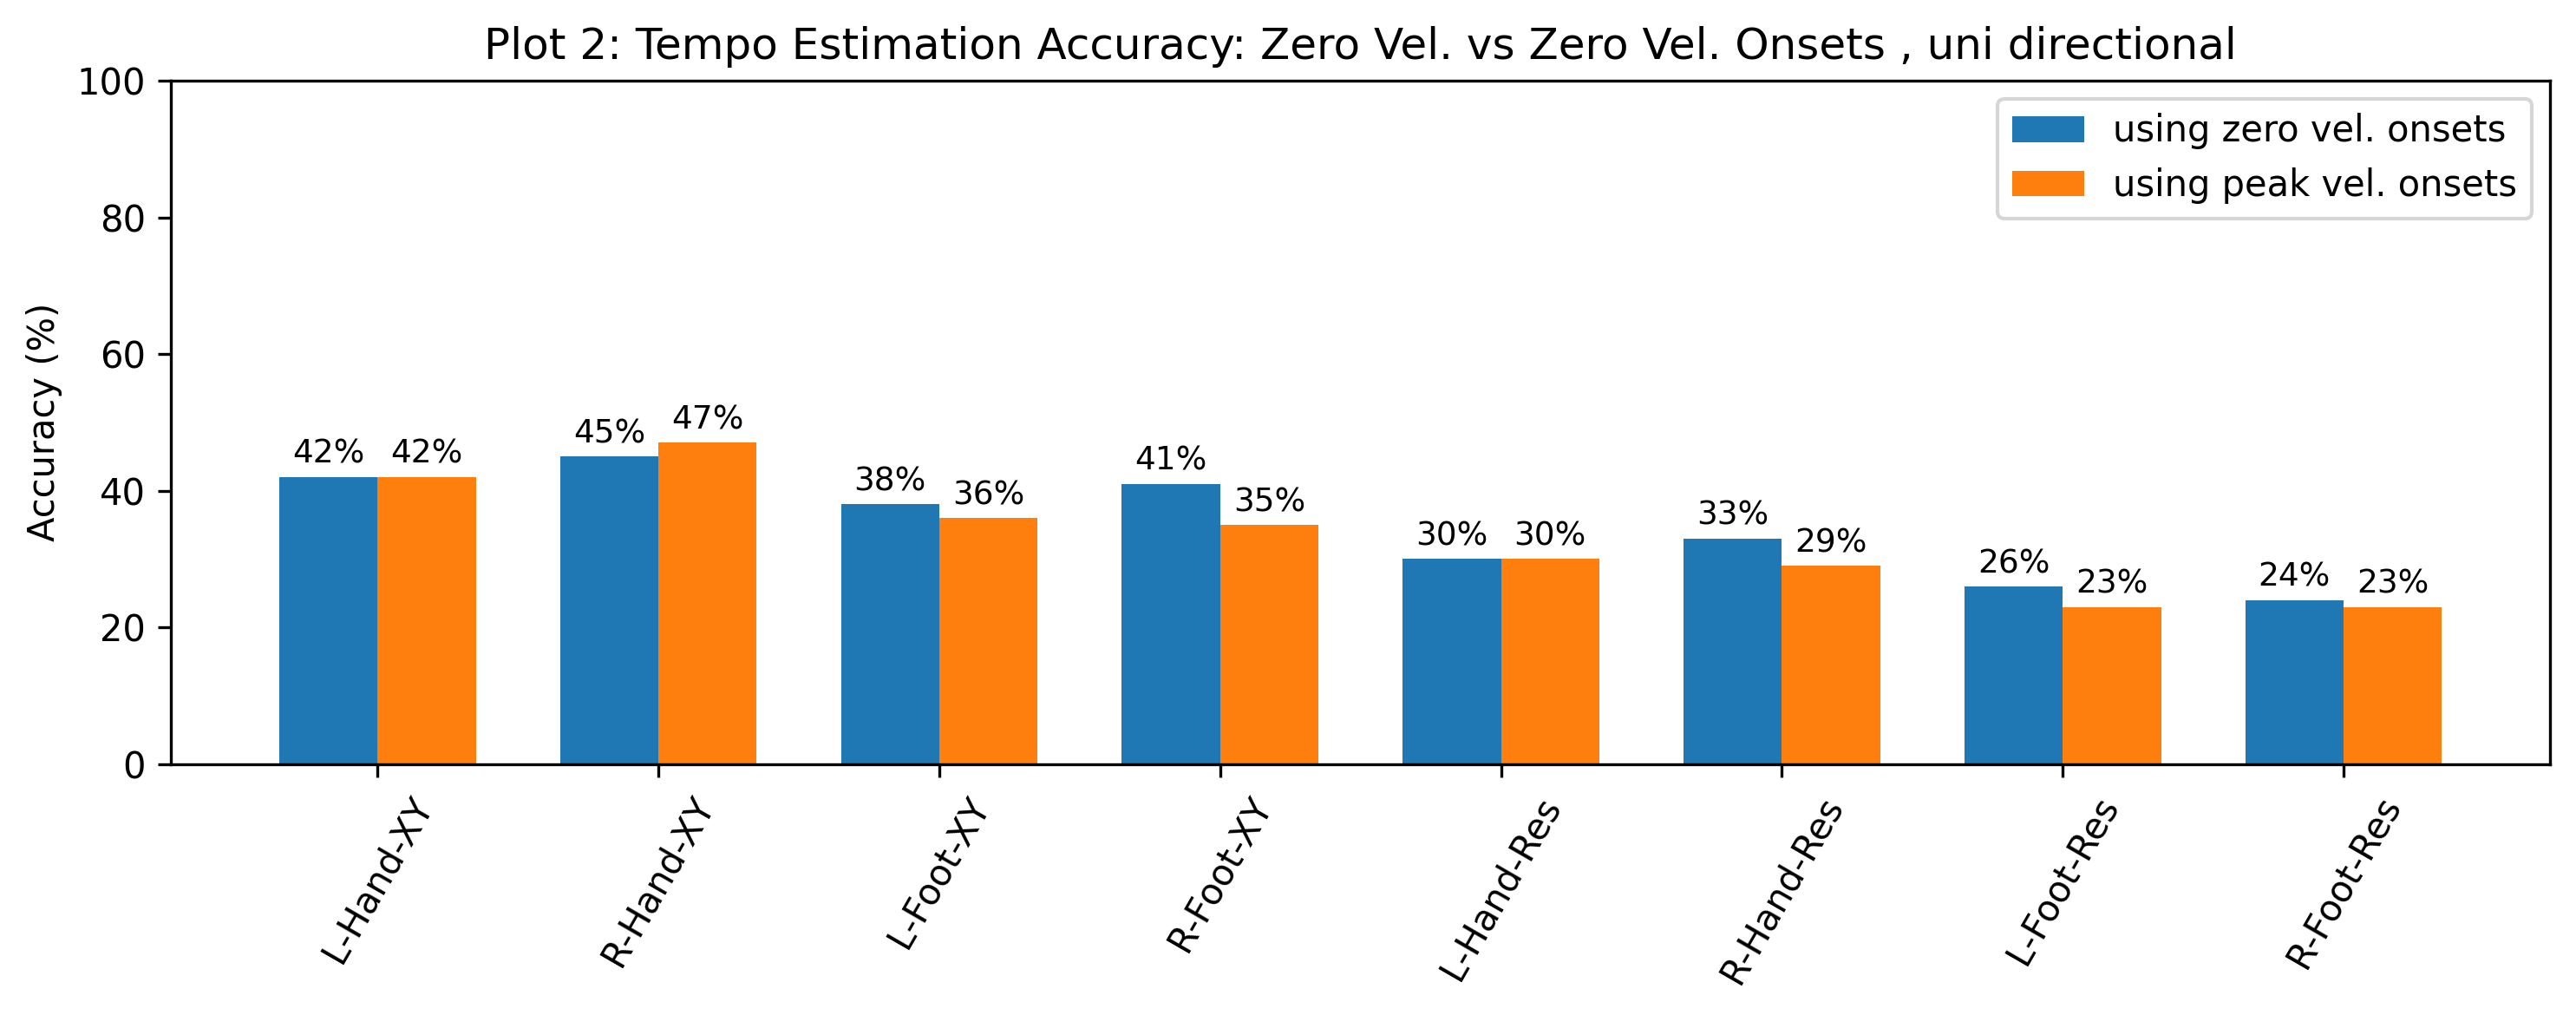

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Your fixed parameters
a, b       = 25, 140
mode       = "zero_uni"
w_sec, h_sec = 5, 5/2

segments = [
    "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",
    "left_hand_resultant", "right_hand_resultant",
    "left_foot_resultant", "right_foot_resultant",
]
labels = [
    'L-Hand-XY', 'R-Hand-XY', 'L-Foot-XY', 'R-Foot-XY',
    'L-Hand-Res','R-Hand-Res','L-Foot-Res','R-Foot-Res'
]

# Compute accuracies for both metrics
acc = {}
for metric in ("pos", "vel"):
    t_data    = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)
    acc[metric] = np.array([
        round(t_data['bpm_median'][seg]['Acc1_bpm_one'])
        for seg in segments
    ])


# Plot setup
# gap   = 0.2                         # reduce this to bring bars closer
# group = bar_width*2 + gap          # two bars per group + small gap
# x = np.arange(len(labels)) * group
# x = np.arange(len(labels)) * (bar_width*2 + 0.2)

x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(10, 4), dpi=300)
# pos bars (left offset)
plt.bar(
    x - bar_width/2,
    acc['pos'],
    bar_width,
    label='using zero vel. onsets',
    color='tab:blue',
    # edgecolor='gray'
)
# vel bars (right offset)
plt.bar(
    x + bar_width/2,
    acc['vel'],
    bar_width,
    label='using peak vel. onsets',
    color='tab:orange',
    # edgecolor='gray'
)

# Labels & titles
plt.xticks(x, labels, rotation=60)
plt.ylabel('Accuracy (%)')
plt.title('Plot 2: Tempo Estimation Accuracy: Zero Vel. vs Zero Vel. Onsets , uni directional')
plt.ylim(0, 100)
plt.legend()

# Annotate each bar
for idx in range(len(x)):
    plt.text(
        x[idx] - bar_width/2, acc['pos'][idx] + 1,
        f"{acc['pos'][idx]}%", ha="center", va="bottom", fontsize=9
    )
    plt.text(
        x[idx] + bar_width/2, acc['vel'][idx] + 1,
        f"{acc['vel'][idx]}%", ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.savefig("plots/plot_2a_multi-axis.png")
plt.show()


### V1: Bar Plot: Both Hand/Foot

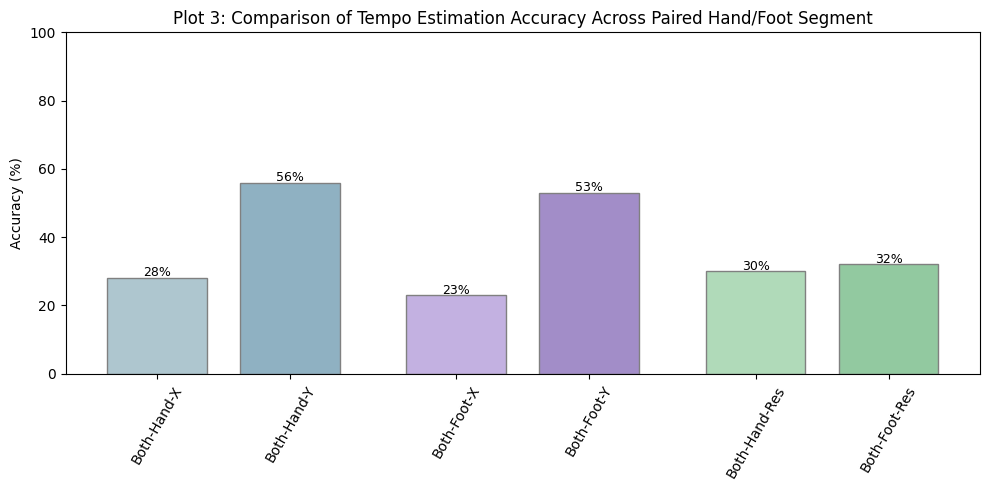

In [14]:
segments_3 = [
        "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
         "both_hand_resultant", "both_foot_resultant", 
        ]   # "bothhand_xy", "bothfoot_xy",

a = 25; b= 140
metric = "pos"
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)

accuracies = [round(t_data['bpm_median'][seg]['Acc1_bpm_one']) for seg in segments_3]

# Define labels
labels = [
    'Both-Hand-X', 'Both-Hand-Y', 'Both-Foot-X', 'Both-Foot-Y',
     'Both-Hand-Res', 'Both-Foot-Res',
]   # 'Both-Hand-XY', 'Both-Foot-XY',

bar_colors = [
    '#AEC6CF', '#8FB1C2',  
    '#C3B1E1', '#A28DC8',  
    '#B0DAB9', '#92C9A0', 
    '#FFDAC1', '#E8BEA3',  
]

# Parameter to control bar width
bar_width = 0.15

# Number of pairs
n_pairs = len(labels) // 2

# Positioning pairs
pair_spacing = 0.15  # space between pairs
inner_spacing = 0.05  # gap between bars within a pair

# Calculate positions for bars to group them in pairs
positions = []
for i in range(n_pairs):
    start_pos = i * (2 * bar_width + pair_spacing)
    positions.extend([start_pos, start_pos + bar_width + inner_spacing])

x = np.array(positions)

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(x, accuracies, color=bar_colors, edgecolor='gray', width=bar_width)

# Customize plot
plt.xticks(x, labels, rotation=60)
plt.ylabel('Accuracy (%)')
plt.title('Plot 3: Comparison of Tempo Estimation Accuracy Across Paired Hand/Foot Segment')
plt.ylim(0, 100)

# Annotate bar heights
for bar in bars:
    plt.text( bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{bar.get_height()}%', ha='center', fontsize=9 )

plt.tight_layout()
plt.show()

### V2: Bar Plot: Both Hand/Foot

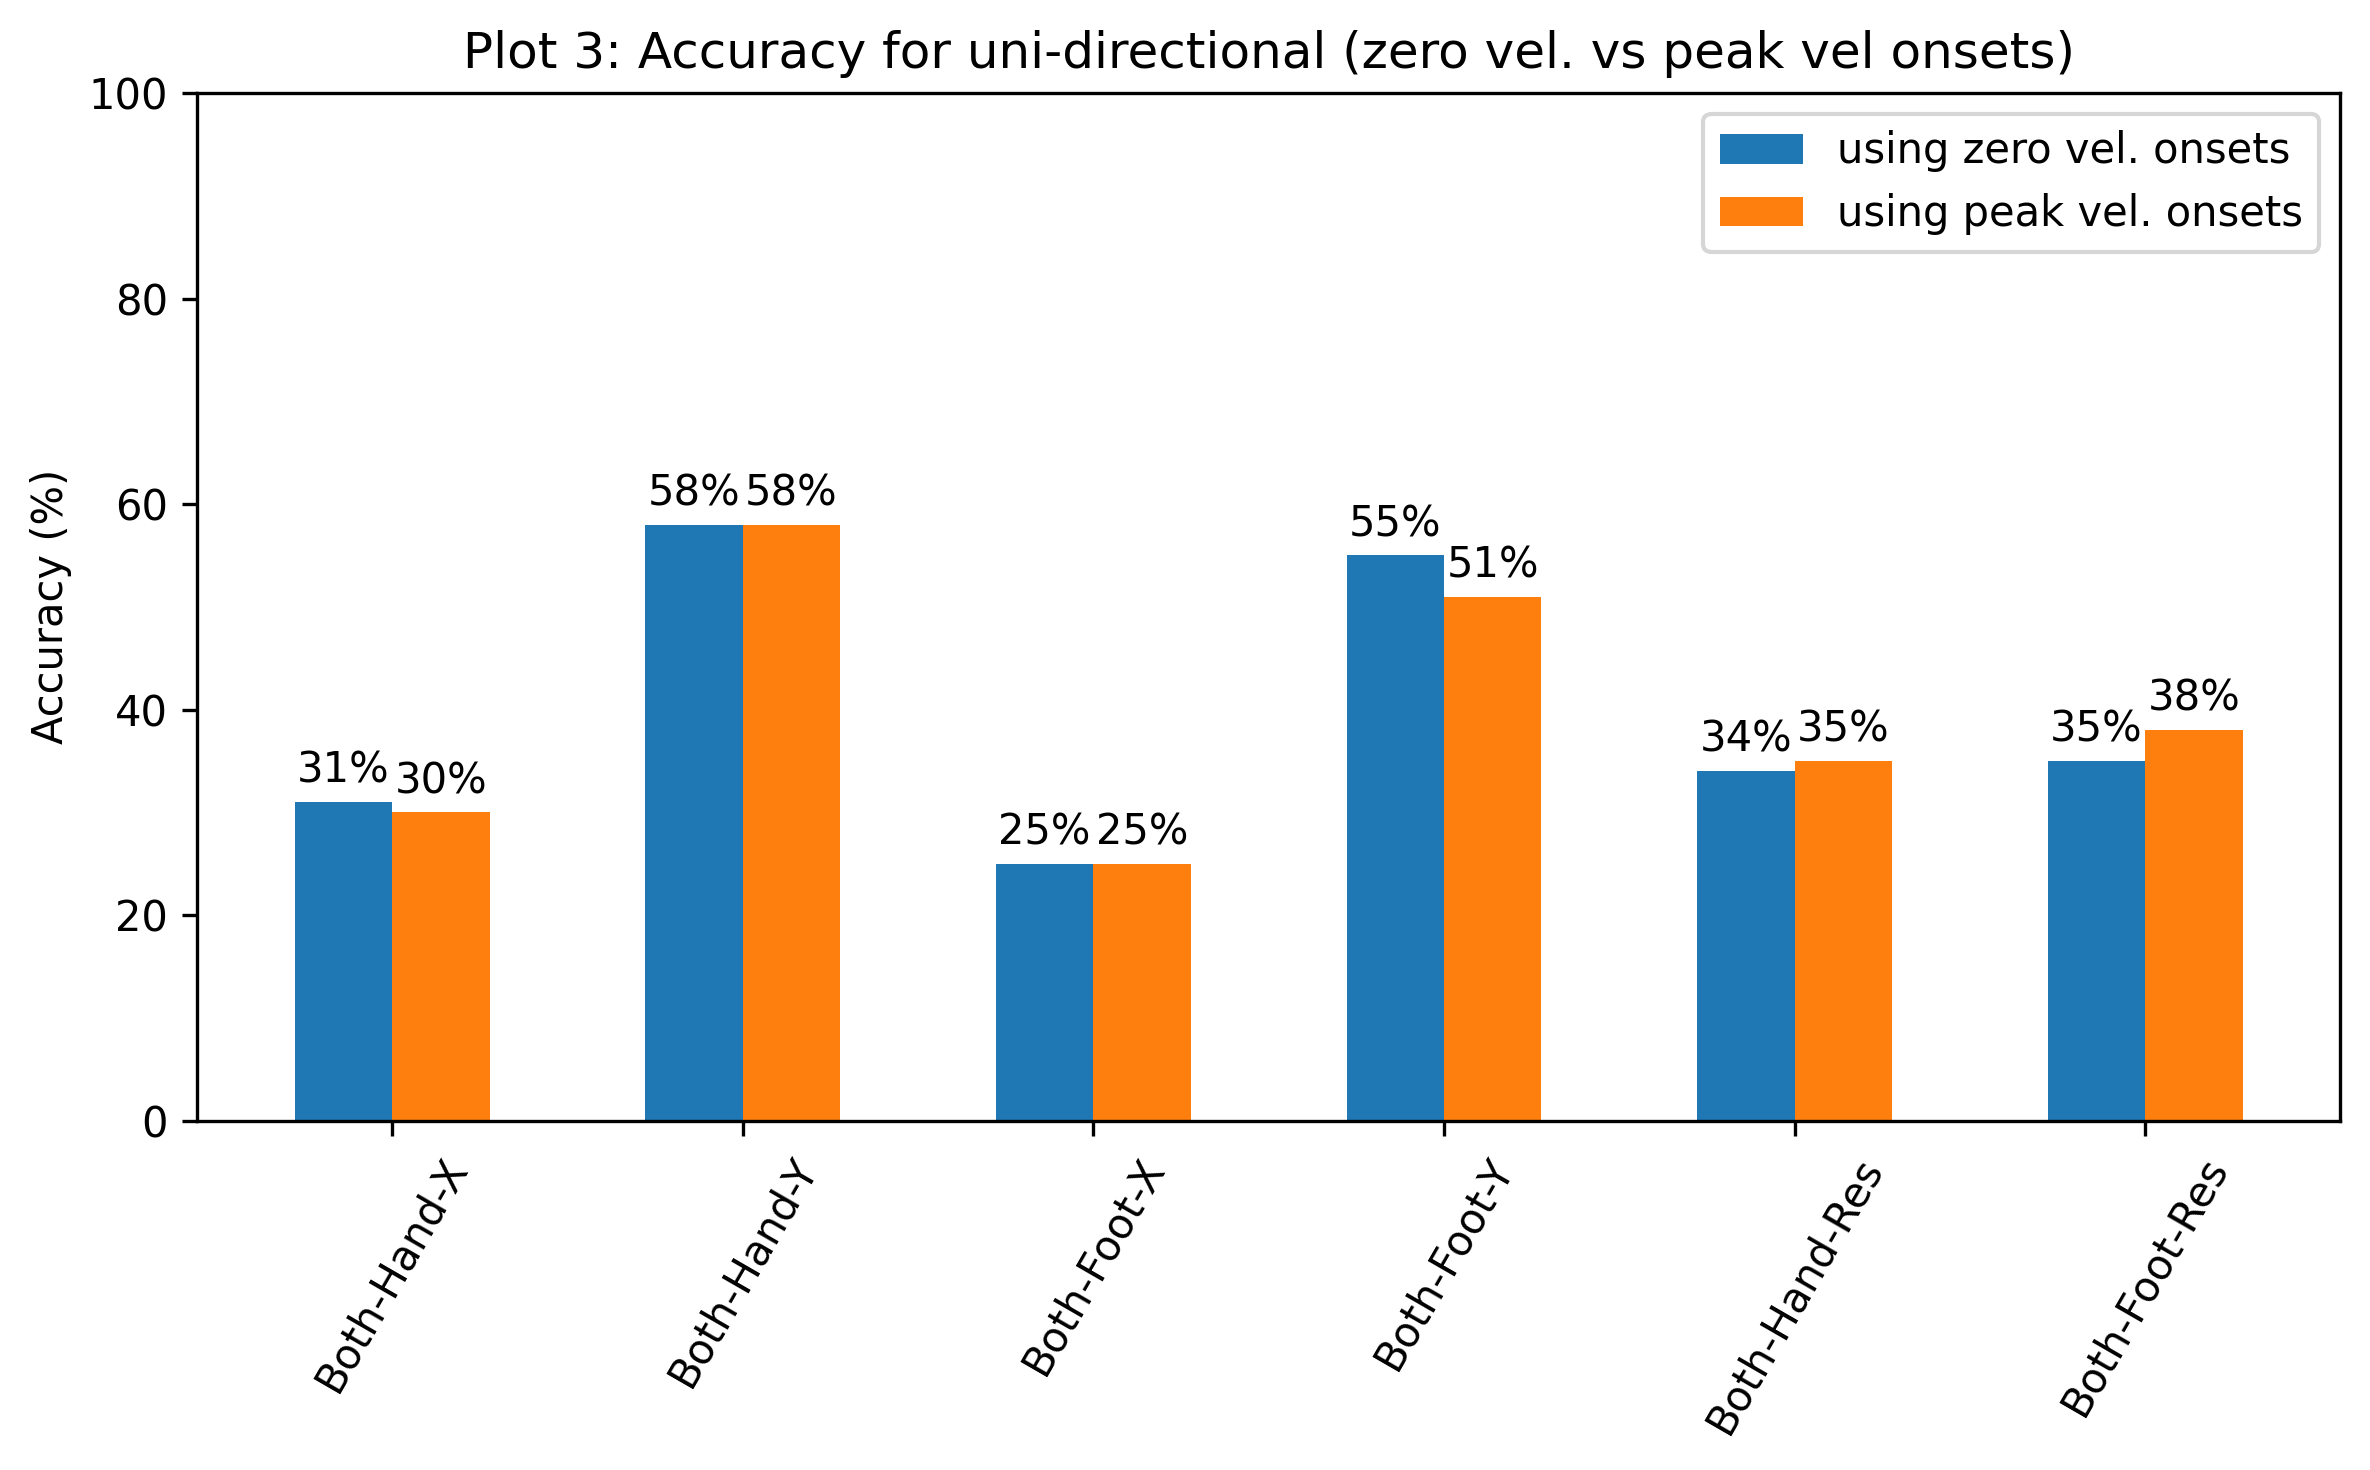

In [26]:
import numpy as np
import matplotlib.pyplot as plt

segments_3 = [
    "both_hand_x", "both_hand_y",
    "both_foot_x", "both_foot_y",
    "both_hand_resultant", "both_foot_resultant",
]

a, b         = 25, 140
mode         = "zero_uni"
w_sec, h_sec = 5, 5/2

# compute pos accuracies
t_pos = estimate_tempo_one(a, b, mode, "pos", w_sec, h_sec)
acc_pos = [round(t_pos['bpm_median'][seg]['Acc1_bpm_one']) for seg in segments_3]

# compute vel accuracies
t_vel = estimate_tempo_one(a, b, mode, "vel", w_sec, h_sec)
acc_vel = [round(t_vel['bpm_median'][seg]['Acc1_bpm_one']) for seg in segments_3]

labels = [
    'Both-Hand-X', 'Both-Hand-Y',
    'Both-Foot-X', 'Both-Foot-Y',
    'Both-Hand-Res','Both-Foot-Res',
]

gap   = 0.2                         # reduce this to bring bars closer
group = bar_width*2 + gap          # two bars per group + small gap
x = np.arange(len(labels)) * group
x = np.arange(len(labels)) * (bar_width*2 + 0.2)
# x = np.arange(len(labels))
bar_width = 0.25

plt.figure(figsize=(8, 5), dpi=300)

# pos in blue
plt.bar(
    x - bar_width/2,
    acc_pos,
    bar_width,
    color='tab:blue',
    # edgecolor='gray',
    label='using zero vel. onsets',
)

# vel in orange
plt.bar(
    x + bar_width/2,
    acc_vel,
    bar_width,
    color='tab:orange',
    # edgecolor='gray',
    label='using peak vel. onsets',
)

plt.xticks(x, labels, rotation=60)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.title('Plot 3: Accuracy for uni-directional (zero vel. vs peak vel onsets)')
plt.legend()

# annotate
for i in range(len(x)):
    plt.text(x[i] - bar_width/2, acc_pos[i] + 1,
             f"{acc_pos[i]}%", ha='center', va='bottom')
    plt.text(x[i] + bar_width/2, acc_vel[i] + 1,
             f"{acc_vel[i]}%", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("plots/plot_3a_both.png")
plt.show()


### Bar Plot: Both Hand+Foot (Multi Score)

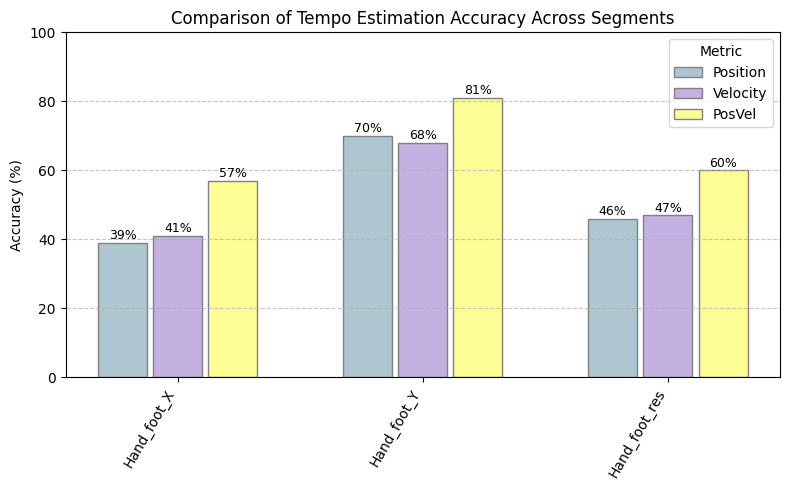

In [17]:
segments_3 = [
        'both_hand_x_both_foot_x', 'both_hand_y_both_foot_y', 
        'both_hand_resultant_both_foot_resultant'
        ]   # , 'bothhand_xy_bothfoot_xy'

a = 25; b= 140
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

t_data = estimate_tempo_posvel(a, b, mode, w_sec, h_sec)
accuracies_pos = [round(t_data['bpm_median'][seg]['Acc1_bpm_pos']) for seg in segments_3]
accuracies_vel = [round(t_data['bpm_median'][seg]['Acc1_bpm_vel']) for seg in segments_3]
accuracies_posvel = [round(t_data['bpm_median'][seg]['Acc1_bpm_posvel']) for seg in segments_3]

labels = [
    'Hand_foot_X', 'Hand_foot_Y','Hand_foot_res', 
]   # , 'Hand_foot_XY' 

# Define colors for each metric as separate variables
pos_color    = '#AEC6CF'   # Color for Position-based accuracy
vel_color    = '#C3B1E1'   # Color for Velocity-based accuracy
posvel_color = '#FDFD96'   # Color for Combined PosVel accuracy

# Set up x-axis positions for groups
x = np.arange(len(labels))
bar_width = 0.2
inner_spacing = 0.05

# Calculate positions for each of the three bars per group
x_pos    = x - (bar_width + inner_spacing/2)
x_vel    = x
x_posvel = x + (bar_width + inner_spacing/2)

# Create the grouped bar plot
plt.figure(figsize=(8, 5))

bars_pos    = plt.bar(x_pos,    accuracies_pos,    width=bar_width, color=pos_color,    edgecolor='gray', label='Position')
bars_vel    = plt.bar(x_vel,    accuracies_vel,    width=bar_width, color=vel_color,    edgecolor='gray', label='Velocity')
bars_posvel = plt.bar(x_posvel, accuracies_posvel, width=bar_width, color=posvel_color, edgecolor='gray', label='PosVel')

plt.xticks(x, labels, rotation=60, ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Tempo Estimation Accuracy Across Segments')
plt.ylim(0, 100)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its value
for bar in bars_pos + bars_vel + bars_posvel:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f'{bar.get_height()}%',
        ha='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()

### Dance Tempo Score

In [3]:
# segment_keys = [
#                 "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
#                 "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                
#                 "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
#                 "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                
#                 "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
#                     "both_hand_resultant", "both_foot_resultant", # resultant of x and y onsets
#                 ]

a = 25; b= 140
metric = "pos"
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

score_data = {}
json_data = {}
# bpm_dict = ["bpm_avg",  "bpm_mode", "bpm_median"]
oPath = f"./saved_result/tempo_{a}_{b}/"

f_name = "both_hand_y"
bpm_mode = "bpm_median"


f_path = oPath + f"{metric}/{f_name}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
df_ax = pd.read_pickle(f_path)

ref_bpm = df_ax["music_tempo"].to_numpy()
estimated_bpm = df_ax[bpm_mode].to_numpy()

In [4]:
genre = {
    "Break": "gBR",
    "Pop": "gPO",
    "Lock": "gLO",
    "Middle Hip-hop": "gMH",
    "LA style Hip-hop": "gLH",
    "House": "gHO",
    "Waack": "gWA",
    "Krump": "gKR",
    "Street Jazz": "gJS",
    "Ballet Jazz": "gJB"
}



df_genre = df_ax[df_ax["dance_genre"] == genre["Middle Hip-hop"]]
ref_bpm = df_genre["music_tempo"].to_numpy()
estimated_bpm = df_genre[bpm_mode].to_numpy()

In [5]:
def compute_dts(ref_bpm, estimated_bpm, tau=0.06):
    """
    Continuous Dance‑Tempo Score (DTS).

    Parameters
    ----------
    ref_bpm : 1‑D array-like
        Ground‑truth musical tempo in BPM.
    estimated_bpm : 1‑D array-like
        Estimated dancer tempo in BPM.
    tau : float, optional
        Tolerance in octaves (0.06 ≈ 4 %).

    Returns
    -------
    dts : ndarray
        Scores in [0, 1] (1 = perfect, 0 = miss ≥ τ octaves away).
    e   : ndarray
        Raw octave errors log2(estimated/ref).
    d   : ndarray
        Wrapped distance to {‑1, 0, +1} before clipping.
    """
    ref_bpm       = np.asarray(ref_bpm, dtype=float)
    estimated_bpm = np.asarray(estimated_bpm, dtype=float)

    # log‑octave error
    e = np.log2(estimated_bpm / ref_bpm)

    # distance to nearest of {‑1, 0, +1}
    d = np.abs(e[:, None] - np.array([-1.0, 0.0, 1.0])).min(axis=1)

    # clip by tolerance and convert to score
    d_clip = np.minimum(d, tau)
    dts    = 1.0 - d_clip / tau
    return dts, e, d




In [ ]:
for key in genre.keys():
    df_genre = df_ax[df_ax["dance_genre"] == genre[key]]
    ref_bpm = df_genre["music_tempo"].to_numpy()
    estimated_bpm = df_genre[bpm_mode].to_numpy()
    tau=0.10
    dts, e, d = compute_dts(ref_bpm, estimated_bpm, tau=tau)
    
    print(f"tau: {tau}")
    print(f"Genre: {key}")
    print(f"Mean DTS          : {dts.mean():.3f}")
    print(f"Median DTS        : {np.median(dts):.3f}")
    print(f"Accuracy DTS ≥0.30: {(dts >= 0.1).mean() * 100:.2f}%")
    print("\n")

tau: 0.2
Mean DTS          : 0.421
Median DTS        : 0.411
Accuracy DTS ≥0.80: 56.00%


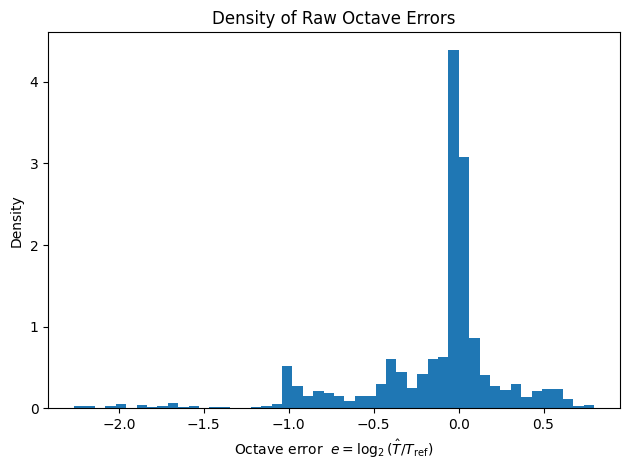

In [10]:
# ------------------------------------------------------------------

# df_genre = df_ax[df_ax["dance_genre"] == genre["Middle Hip-hop"]]
# ref_bpm = df_genre["music_tempo"].to_numpy()
# estimated_bpm = df_genre[bpm_mode].to_numpy()


ref_bpm = df_ax["music_tempo"].to_numpy()
estimated_bpm = df_ax[bpm_mode].to_numpy()

### adaptive ###
# bhf  = load_pickle("/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result/tttempo_60_140/pos/bhf_zero_uni_W5_H2.5_60_140.pkl")
# ref_bpm = bhf["music_tempo"].to_numpy()
# estimated_bpm = np.asarray(bhf["bpm_median"], dtype=float)

dts, e, d = compute_dts(ref_bpm, estimated_bpm, tau=0.10)

print(f"tau: 0.2")
print(f"Mean DTS          : {dts.mean():.3f}")
print(f"Median DTS        : {np.median(dts):.3f}")
print(f"Accuracy DTS ≥0.80: {(dts > 0.1).mean() * 100:.2f}%")

# ------------------------------------------------------------------
# Visualise the score distribution ---------------------------------
# plt.figure()
# plt.hist(dts, bins=30)
# plt.xlabel("Dance‑Tempo Score (DTS)")
# plt.ylabel("Count")
# plt.title("Distribution of DTS")
# plt.tight_layout()
# plt.show()

plt.figure()
plt.hist(e, bins=50, density=True)
plt.xlabel("Octave error  $e = \\log_2(\\hat{T}/T_{\\mathrm{ref}})$")
plt.ylabel("Density")
plt.title("Density of Raw Octave Errors")
plt.tight_layout()

In [19]:
import numpy as np

def percent_band(tau):
    """
    Compute p(τ) = (2^τ − 1) × 100%
    
    Args:
      tau: scalar or array of octave widths
    Returns:
      p: same shape as tau, percent band
    """
    return (2**tau - 1) * 100

def bpm_band(T_ref, tau):
    """
    Given reference BPM T_ref and octave width tau,
    return (BPM_min, BPM_max) of the symmetric τ-band.
    """
    p = percent_band(tau) / 100.0
    return T_ref * (1 - p), T_ref * (1 + p)

# Example usage:
if __name__ == "__main__":
    # your example taus
    taus = np.array([0.06, 0.10, 0.20])
    T_ref = 120.0  # example reference BPM
    
    # compute percent bands
    p_vals = percent_band(taus)
    print(p_vals)
    # compute rule-of-thumb linear approximation for small tau
    # rule_of_thumb = 69.3 * taus  # percent
    
    # print table header
    # print(f"{'τ (oct)':>7} | {'p(τ) [%]':>8} | {'≈ rule-of-thumb [%]':>18}")
    # print("-"*40)
    
    # print rows
    # for τ, p, rot in zip(taus, p_vals, rule_of_thumb):
    #     print(f"{τ:7.2f} | {p:8.1f} | {rot:18.1f}")
    
    print("\nExample BPM bands (T_ref = {:.1f}):".format(T_ref))
    for τ in taus:
        lo, hi = bpm_band(T_ref, τ)
        print(f"  τ = {τ:.2f} → [{lo:.1f}, {hi:.1f}] BPM")


[ 4.24657608  7.17734625 14.8698355 ]

Example BPM bands (T_ref = 120.0):
  τ = 0.06 → [114.9, 125.1] BPM
  τ = 0.10 → [111.4, 128.6] BPM
  τ = 0.20 → [102.2, 137.8] BPM
